### Information theory and nudge impact

This notebook has as purpose to research the relation between information theoretical measures 
(mostly mutual information) and nudge impact of different nudges.

In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import json
import collections

import numpy as np
from scipy.stats import entropy

from jointpdf.jointpdf import JointProbabilityMatrix
from jointpdf.jointpdf import NestedArrayOfProbabilities
from jointpdf.jointpdf import FullNestedArrayOfProbabilities
from extension_probability_matrix import JointProbabilityMatrixExtended

import probability_distributions
from probability_distributions import ProbabilityArray
import nudge
import nudge_non_causal as nudge_new
import plotting
import simulate
from information_theory import calculate_mutual_information
import information_theory


In [2]:
def calculate_amount_and_size_nudges(total_nudge_size, number_of_states, threshold=10):
    """
    Calculate the nudge size and the number of nudges that need to be performed 
    to nudge a variable with the total nudge size. Assuming the distribution is
    not too peaked, in other words, not too many states should have a probability
    that is 10 times smaller than normal.
    
    Parameters:
    ----------
    total_nudge_size: a number
        How much the variable need to be nudged
    number_of_states: a number
        The total number of states of the joint distribution
    threshold: a float 
        Indicating how much smaller than uniform the value of the number
        at the 95-99 percentile of points is. Defaults to 10 
        
    Returns: local_nudge, number_of_nudges
    -------
    local_nudge: a number 
        The size of the local nudge to be performed on the joint distribution
    number_of_nudges: integer
        How often the nudge need to be performed
    
    """
    assumed_min_size = 1.0/threshold
    max_local_nudge = min(total_nudge_size, 0.1/number_of_states)
    number_of_nudges = int(np.ceil(total_nudge_size/max_local_nudge))
    local_nudge = total_nudge_size/float(number_of_nudges) 
    return local_nudge, number_of_nudges

def generate_distribution(shape, method, arguments=None):
    if method=='random_biased':
        distribution = np.random.random(shape)
        distribution = distribution/np.sum(distribution)
        return distribution
    elif method=='random_dirichlet':
        return probability_distributions.compute_joint_uniform_random(shape)
    elif method=='fixed_entropy':
        return probability_distributions.generate_probability_distribution_with_certain_entropy(
            shape, arguments['entropy_size']
        )
    else:
        raise ValueError('provide a valid method')
        
def percentage_max_entropy(shape, percentage):
    """ 
    Return the percentage of the max-entropy given the shape
    
    Parameters:
    ----------
    shape: iterable
    percentage: float
    
    """
    return np.log2(reduce(lambda x,y: x*y, shape)) * percentage

def percentage_states_max_entropy(shape, percentage):
    """ 
    Return the percentage of the max-entropy given the shape
    
    Parameters:
    ----------
    shape: iterable
    percentage: float
    
    """
    return np.log2(reduce(lambda x,y: x*y, shape) * percentage)

def transfer_ndarray_to_joint_probability_matrix(array):
    """
    array: nd-array
        All axis should have the same size
        
    """
    shape = array.shape
    if not all([item==shape[0] for item in shape]):
        raise ValueError("all variables need to have same number of states")
    
    number_of_variables = len(shape) 
    number_of_states = shape[0]
    return JointProbabilityMatrix(number_of_variables, number_of_states, array)

## EXPERIMENT 1:

How do mutual information and nudge impact relate for one input variable and one output variable.
The joint of the input and output variables is generated randomly biased

In [3]:
def effect_of_nudge_1d(distribution, nudge_size):
    """
    Nudge the input variable and calculate the effect on the output variable
    (the KL-devergence of the output variable)
    
    Parameters:
    ----------
    distribution: a numpy array
        It should represent the joint probability distribution of 1 input
        (the first axis) and 1 output variable (the second axis).
    nudge_size: a number
    
    Returns: a number
    """
    probability_array_old = ProbabilityArray(distribution)
    marginal_variable_old = probability_array_old.marginalize(set([0]))
    marginal_function_old = probability_array_old.marginalize(set([1]))
    conditional_joint_old, marginal_labels_old, conditional_labels_old = (
        probability_array_old.find_conditional(set([1]), set([0]))
    )
    marginal_variable_nudged, nudges_states = nudge.nudge(
        marginal_variable_old, nudge_size
    )
    joint_new = ProbabilityArray(probability_distributions.compute_joint(
        marginal_variable_nudged, conditional_joint_old, conditional_labels_old
    ))
    marginal_function_new = joint_new.marginalize(set([1]))  
    kl_variable = entropy(marginal_variable_old, marginal_variable_nudged)
    kl_function = entropy(marginal_function_old, marginal_function_new) 
    return kl_variable, kl_function

#this is a biased result replace by dirichlet distribution
#pdf = JointProbabilityMatrix(1, 10, 'random')

#non-biased result
number_of_input_vars = 1
number_of_states = 5
dist = np.random.dirichlet([1] * number_of_states**number_of_input_vars)
pdf = transfer_ndarray_to_joint_probability_matrix(dist)

print("looking for targer mi")
pdf.append_variables_with_target_mi(1, 0.5)
print("found target mi")
distribution = pdf.joint_probabilities.joint_probabilities
effect_of_nudge_1d(distribution, 0.01)

looking for targer mi
found target mi


(0.00081432905547886014, 7.2607124071092516e-05)

#### Perform actual experiment

In [10]:
#see whether and how mutual information and response to the nudge co-depend
NUMBER_OF_STATES, NUDGE_SIZE = 5, 0.01
number_of_input_vars = 1
#mutual_information_sizes = np.arange(0.05, 1, 0.05)
mutual_information_sizes = np.arange(0.35, 1, 0.05)
sample_size = 200
effect_nudge_given_mi = {}

RUN = False
FILE_NAME = "data_experiments/relation_MI_nudge_impact_1input_non_biased2.json"
if RUN:
    for mutual_information_size in mutual_information_sizes:
        print("the mutual information size is {}".format(mutual_information_size))
        nudge_effects = []
        for sample in range(sample_size):
            #pdf = JointProbabilityMatrix(1, NUMBER_OF_STATES, 'random')
            dist = np.random.dirichlet([1] * NUMBER_OF_STATES**number_of_input_vars)
            pdf = transfer_ndarray_to_joint_probability_matrix(dist)

            pdf.append_variables_with_target_mi(1, mutual_information_size)
            distribution = pdf.joint_probabilities.joint_probabilities
            output_marginal = probability_distributions.ProbabilityArray(distribution).marginalize(set([1]))
            if np.any(output_marginal < 0.01):
                continue

            nudge_impact = np.mean([effect_of_nudge_1d(distribution, 0.01)[1] for _ in range(100)])
            nudge_effects.append(nudge_impact)

        effect_nudge_given_mi[mutual_information_size] = nudge_effects
        with open(FILE_NAME, 'w') as f:
            json.dump(effect_nudge_given_mi, f)

    #print(effect_nudge_given_mi)

the mutual information size is 0.35
the mutual information size is 0.4
the mutual information size is 0.45
the mutual information size is 0.5
the mutual information size is 0.55
the mutual information size is 0.6
the mutual information size is 0.65
the mutual information size is 0.7
the mutual information size is 0.75
the mutual information size is 0.8
the mutual information size is 0.85
the mutual information size is 0.9
the mutual information size is 0.95


In [6]:
if RUN:
    plot_range, mean, std, batches_stc = simulate.find_mean_std_mse(
        effect_nudge_given_mi, 
    )
    print(mean)
    import scipy
    print()
    scipy.stats.linregress(plot_range, mean)

### Experiment 3

#### mutual information between output and individual input for fixed total entropy

Experiment:
The relation between nudge impact and the mutual information between the output variable and
the nudged input variable.


In [7]:
NUMBER_OF_VARIABLES, NUMBER_OF_STATES, TOTAL_NUDGE_SIZE = 1, 5, 0.01
shape = tuple([NUMBER_OF_STATES]*(NUMBER_OF_VARIABLES+1))
NUMBER_OF_SAMPLES = 200

PERCENTAGE_MAX_ENTROPY = 0.75
SAMPLES_TO_ESTIMATE_NUDGE_IMPACT = 1000
MIN_PROBABILITY_OUTPUT_STATE = 0.01

local_nudge_size, number_of_nudges = calculate_amount_and_size_nudges(
    TOTAL_NUDGE_SIZE, NUMBER_OF_STATES**NUMBER_OF_VARIABLES
)
impact_nudges_and_mi = []

DATA_PATH = "data_experiments/"
FILE_NAME = "correlation_MI_individual_nudge_impact_1var_5states_min_output001.json"
RUN = False
if RUN:
    for i in range(NUMBER_OF_SAMPLES):
        if i%2==0 and i != 0:
            print("sample number {}".format(i))

        #calculate the distribution
        #distribution = ProbabilityArray(generate_distribution(shape, 'random_dirichlet'))
        distribution = ProbabilityArray(generate_distribution(
                shape, 'fixed_entropy', 
                {"entropy_size":percentage_max_entropy(shape, PERCENTAGE_MAX_ENTROPY)}
        ))
        function_label, label_nudged_variable = NUMBER_OF_VARIABLES, 0
        function_labels = set([function_label])
        input_variable_labels = set(range(len(distribution.probability_distribution.shape))) - function_labels
        
        output_marginal = distribution.marginalize(function_labels)
        if np.any(output_marginal < MIN_PROBABILITY_OUTPUT_STATE):
            continue
            print("dismissing output")

        #calculate mutual information
        mutual_information = calculate_mutual_information(distribution, 
                                                          set([function_label]),
                                                          set([label_nudged_variable]))

        #calculate_nudge_impact
        input_distribution = distribution.marginalize(input_variable_labels)
        nudge_impacts = []
        for _ in range(SAMPLES_TO_ESTIMATE_NUDGE_IMPACT):
            new_input_distribution = nudge.nudge_distribution_local_non_causal(
                input_distribution, 0, local_nudge_size, number_of_nudges
            )
            nudge_impacts.append(nudge.impact_nudge_causal_output(
                distribution, function_labels, new_input_distribution
            ))
        nudge_impact = np.mean(nudge_impacts)
        impact_nudges_and_mi.append((nudge_impact, mutual_information))
        with open(DATA_PATH + FILE_NAME, 'w') as f:
            json.dump(impact_nudges_and_mi, f, indent=2)


In [8]:
import matplotlib.pyplot as plt
import scipy

if RUN:
    impact_nudges = [item[0] for item in impact_nudges_and_mi] 
    mutual_information_sizes = [item[1] for item in impact_nudges_and_mi]
    plt.plot(mutual_information_sizes, impact_nudges, 'o')
    plt.show()

    scipy.stats.linregress(impact_nudges, mutual_information_sizes)


#### The same experiment for vector nudges

In [11]:
NUMBER_OF_VARIABLES, NUMBER_OF_STATES, TOTAL_NUDGE_SIZE = 1, 5, 0.01
shape = tuple([NUMBER_OF_STATES]*(NUMBER_OF_VARIABLES+1))
NUMBER_OF_SAMPLES = 500

PERCENTAGE_MAX_ENTROPY = 0.75
SAMPLES_TO_ESTIMATE_NUDGE_IMPACT = 20000
MIN_PROBABILITY_OUTPUT_STATE = 0.01

local_nudge_size, number_of_nudges = calculate_amount_and_size_nudges(
    TOTAL_NUDGE_SIZE, NUMBER_OF_STATES**NUMBER_OF_VARIABLES
)
impact_nudges_and_mi = []

DATA_PATH = "data_experiments/"
FILE_NAME = "correlation_MI_individual_vector_nudge_impact_5var_5states_l1norm_ex1_20000.json"
RUN = True
if RUN:
    for i in range(NUMBER_OF_SAMPLES):
        if i%2==0 and i != 0:
            print("sample number {}".format(i))

        #calculate the distribution
        #distribution = ProbabilityArray(generate_distribution(shape, 'random_dirichlet'))
        distribution = ProbabilityArray(generate_distribution(
                shape, 'fixed_entropy', 
                {"entropy_size":percentage_max_entropy(shape, PERCENTAGE_MAX_ENTROPY)}
        ))
        function_label, label_nudged_variable = NUMBER_OF_VARIABLES, NUMBER_OF_VARIABLES-1
        function_labels = set([function_label])
        input_variable_labels = set(range(len(distribution.probability_distribution.shape))) - function_labels
        
#         output_marginal = distribution.marginalize(function_labels)
#         if np.any(output_marginal < MIN_PROBABILITY_OUTPUT_STATE):
#             continue
#             print("dismissing output")

        #calculate mutual information
        mutual_information = calculate_mutual_information(distribution, 
                                                          set([function_label]),
                                                          set([label_nudged_variable]))

        #calculate_nudge_impact
        input_distribution = distribution.marginalize(input_variable_labels)
        cond_output, marginal_labels, cond_labels = distribution.find_conditional(
            function_labels, input_variable_labels
        )
        nudge_impacts = []
        for _ in range(SAMPLES_TO_ESTIMATE_NUDGE_IMPACT):
            new_input_distribution = nudge_new.nudge_individual_without_conditional(
                input_distribution, TOTAL_NUDGE_SIZE
            )
            nudge_impact = nudge_new.find_nudge_impact(
                input_distribution, new_input_distribution, cond_output, measure="absolute"
            )
            nudge_impacts.append(nudge_impact)
            
        nudge_impact = np.mean(nudge_impacts)
        impact_nudges_and_mi.append((nudge_impact, mutual_information))
        with open(DATA_PATH + FILE_NAME, 'w') as f:
            json.dump(impact_nudges_and_mi, f, indent=2)


sample number 2
sample number 4
sample number 6
sample number 8
sample number 10
sample number 12
sample number 14
sample number 16
sample number 18
sample number 20
sample number 22
sample number 24
sample number 26
sample number 28
sample number 30
sample number 32
sample number 34
sample number 36
sample number 38
sample number 40
sample number 42
sample number 44
sample number 46
sample number 48
sample number 50
sample number 52
sample number 54
sample number 56
sample number 58
sample number 60
sample number 62
sample number 64
sample number 66
sample number 68
sample number 70
sample number 72
sample number 74
sample number 76
sample number 78
sample number 80
sample number 82
sample number 84
sample number 86
sample number 88
sample number 90
sample number 92
sample number 94
sample number 96
sample number 98
sample number 100
sample number 102
sample number 104
sample number 106
sample number 108
sample number 110
sample number 112
sample number 114
sample number 116
sample nu

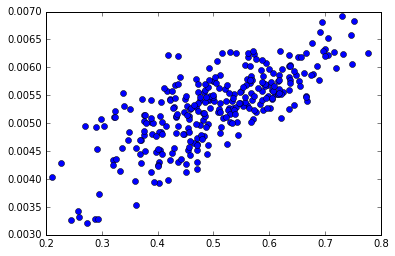

LinregressResult(slope=125.65340430760394, intercept=-0.16031953496432216, rvalue=0.74899663158714058, pvalue=3.2860336016997952e-55, stderr=6.4390311207633513)


In [9]:
import matplotlib.pyplot as plt
import scipy

if RUN:
    impact_nudges = [item[0] for item in impact_nudges_and_mi] 
    mutual_information_sizes = [item[1] for item in impact_nudges_and_mi]
    plt.plot(mutual_information_sizes, impact_nudges, 'o')
    plt.show()

    print(scipy.stats.linregress(impact_nudges, mutual_information_sizes))


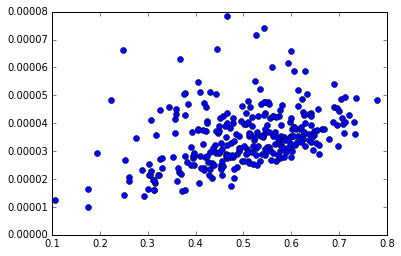

LinregressResult(slope=4251.2036942087052, intercept=0.3512000531602375, rvalue=0.38200650290782695, pvalue=7.9773819446922005e-12, stderr=596.77404945465651)


In [7]:
if RUN:
    impact_nudges_and_mi2 = [item for item in impact_nudges_and_mi if item[0]<0.0001]
        
    impact_nudges = [item[0] for item in impact_nudges_and_mi2] 
    mutual_information_sizes = [item[1] for item in impact_nudges_and_mi2]
    plt.plot(mutual_information_sizes, impact_nudges, 'o')
    plt.show()
    print(scipy.stats.linregress(impact_nudges, mutual_information_sizes))

